#Dataset Creation

In [1]:
#Install dependencies
!pip install pyspark==3.5.0 delta-spark==3.1.0
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

#Build Spark session with Delta enabled
builder = (
    SparkSession.builder.appName("DeltaDemo")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog"))
spark = configure_spark_with_delta_pip(builder).getOrCreate()

#Create sample DataFrame
data = [
    (1, "John", "Electronics", 2, 300),
    (2, "Sara", "Clothing", 1, 50),
    (3, "Mike", "Electronics", 4, 600),
    (4, "Nina", "Clothing", 3, 150),]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)

#Save as Delta table in a given path
delta_path = "/tmp/orders_delta"
df.write.format("delta").mode("overwrite").save(delta_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=efbf59843523be85b1586c6c72720369dab60b3d55bd1199b96796731d728de3
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


# 1. Managed vs Unmanaged Tables

In [2]:
#Create a Managed table (stored in Databricks warehouse location)
spark.sql(f"""
    CREATE TABLE orders_managed
    USING DELTA
    LOCATION '{delta_path}'""")

#Create an Unmanaged table (points to the same location)
spark.sql(f"""
    CREATE TABLE orders_unmanaged
    USING DELTA
    LOCATION '{delta_path}'""")

#Verify
spark.sql("SHOW TABLES").show()

+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|  orders_managed|      false|
|  default|orders_unmanaged|      false|
+---------+----------------+-----------+



#  2. CRUD Operations

In [3]:
#Read table
df_orders = spark.read.format("delta").load(delta_path)
df_orders.show()

# UPDATE: Increase Clothing orders amount by 20
spark.sql(f"""
    UPDATE delta.`{delta_path}`
    SET amount = amount + 20
    WHERE category = 'Clothing'""")

# DELETE: Remove orders with quantity < 2
spark.sql(f"""
    DELETE FROM delta.`{delta_path}`
    WHERE quantity < 2""")

# MERGE: New and updated data
new_data = [
    (3, "Mike", "Electronics", 4, 650),  # Updated order
    (5, "Liam", "Clothing", 2, 80),]     # New order

df_new = spark.createDataFrame(new_data, columns)
df_new.createOrReplaceTempView("new_orders")

spark.sql(f"""
    MERGE INTO delta.`{delta_path}` AS target
    USING new_orders AS source
    ON target.order_id = source.order_id
    WHEN MATCHED THEN UPDATE SET *
    WHEN NOT MATCHED THEN INSERT *""")

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



DataFrame[num_affected_rows: bigint, num_updated_rows: bigint, num_deleted_rows: bigint, num_inserted_rows: bigint]

# 3. History & Time Travel

In [4]:
# Show change history
spark.sql(f"DESCRIBE HISTORY delta.`{delta_path}`").show(truncate=False)

# Read old version (version 0)
old_df = spark.read.format("delta").option("versionAsOf", 0).load(delta_path)
print("Version 0:")
old_df.show()

# Read latest version
latest_df = spark.read.format("delta").load(delta_path)
print("Latest version:")
latest_df.show()

+-------+-----------------------+------+--------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|vers

#  4. Incremental Load Pattern

In [5]:
# Mini-batch with only new orders
batch_new = [
    (6, "Sophia", "Electronics", 1, 200),
    (7, "Emma", "Clothing", 5, 300)]
df_batch_new = spark.createDataFrame(batch_new, columns)

# Append to Delta table
df_batch_new.write.format("delta").mode("append").save(delta_path)

# Show final result
spark.read.format("delta").load(delta_path).show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   650|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|   Clothing|       2|    80|
|       6|       Sophia|Electronics|       1|   200|
|       1|         John|Electronics|       2|   300|
|       7|         Emma|   Clothing|       5|   300|
+--------+-------------+-----------+--------+------+



#  5. Simple Streaming Read

In [9]:
from pyspark.sql.functions import *

# Streaming read from delta table
stream_df = (
    spark.readStream.format("delta")
    .load(delta_path))

query = (
    stream_df.writeStream
    .outputMode("append")
    .format("console")
    .trigger(processingTime="5 seconds")
    .start())

# query.awaitTermination()  #Uncomment to run continuously

# 6. Visualization

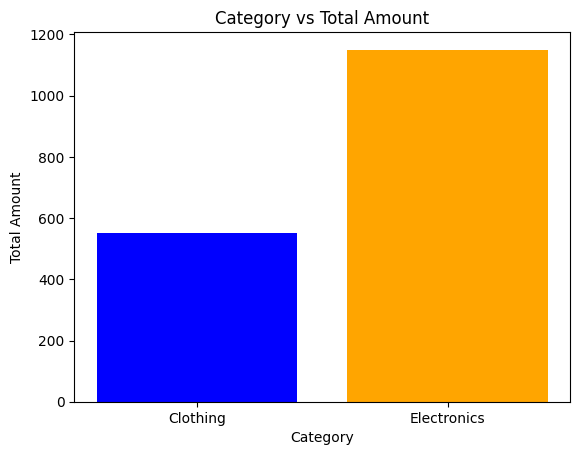

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = spark.read.format("delta").load(delta_path).toPandas()

# Aggregate total amount by category
category_sum = pdf.groupby("category")["amount"].sum().reset_index()

# Plot
plt.bar(category_sum["category"], category_sum["amount"], color=['blue', 'orange'])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()